# AS & WITH

## WITH ... AS
On its own, AS is a convenient way to clean up the data returned by your query. It's even more powerful when combined with WITH in what's called a "common table expression".

A common table expression (or CTE) is a temporary table that you return within your query. CTEs are helpful for splitting your queries into readable chunks, and you can write queries against them.

## Example: How many Bitcoin transactions are made per month?
We're going to use a CTE to find out how many Bitcoin transactions were made each day for the entire timespan of a bitcoin transaction dataset.

In [2]:
from google.cloud import bigquery

client = bigquery.Client(project="sqlbigquery7711")

dataset_ref = client.dataset("crypto_bitcoin", project="bigquery-public-data")

dataset = client.get_dataset(dataset_ref)

In [4]:
tables = list(client.list_tables(dataset))

In [5]:
for table in tables:
    print (table.table_id)

blocks
inputs
outputs
transactions


In [7]:
table_ref = dataset_ref.table("transactions")
table = client.get_table(table_ref)

In [8]:
client.list_rows(table, max_results=5).to_dataframe()


,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,275,275,1,0,00000000dc55860c8a29c58d45209318fa9e9dc2c1833a...,181,2009-01-12 06:02:13+00:00,2009-01-01,1,2,4000000000.000000000,4000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'f4184...","[{'index': 0, 'script_asm': '04b5abd412d4341b4..."
1,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,275,275,1,0,0000000054487811fc4ff7a95be738aa5ad9320c394c48...,182,2009-01-12 06:12:16+00:00,2009-01-01,1,2,3000000000.000000000,3000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'a16f3...","[{'index': 0, 'script_asm': '0401518fa1d1e1e3e..."
2,12b5633bad1f9c167d523ad1aa1947b2732a865bf5414e...,276,276,1,0,00000000f46e513f038baf6f2d9a95b2a28d8a6c985bcf...,183,2009-01-12 06:34:22+00:00,2009-01-01,1,2,2900000000.000000000,2900000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '591e9...","[{'index': 0, 'script_asm': '04baa9d3665315562..."
3,828ef3b079f9c23829c56fe86e85b4a69d9e06e5b54ea5...,276,276,1,0,00000000fb5b44edc7a1aa105075564a179d65506e2bd2...,248,2009-01-12 20:04:20+00:00,2009-01-01,1,2,2800000000.000000000,2800000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '12b56...","[{'index': 0, 'script_asm': '04bed827d37474bef..."
4,35288d269cee1941eaebb2ea85e32b42cdb2b04284a56d...,277,277,1,0,00000000689051c09ff2cd091cc4c22c10b965eb8db3ad...,545,2009-01-15 05:48:32+00:00,2009-01-01,1,2,2500000000.000000000,2500000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'd71fd...","[{'index': 0, 'script_asm': '044a656f065871a35..."


Since the block_timestamp column contains the date of each transaction in DATETIME format, we'll convert these into DATE format using the DATE() command.

We do that using a CTE, and then the next part of the query counts the number of transactions for each date and sorts the table so that earlier dates appear first.

In [14]:
query = """
        WITH time AS 
        (
            SELECT DATE(block_timestamp) AS trans_date
            FROM `bigquery-public-data.crypto_bitcoin.transactions`        
        )
        SELECT COUNT(1) AS transactions, trans_date 
        FROM time
        GROUP BY trans_date 
        ORDER BY trans_date
"""

query_job = client.query(query)

df_query = query_job.to_dataframe()

df_query.head()


,transactions,trans_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12


<Axes: xlabel='trans_date'>

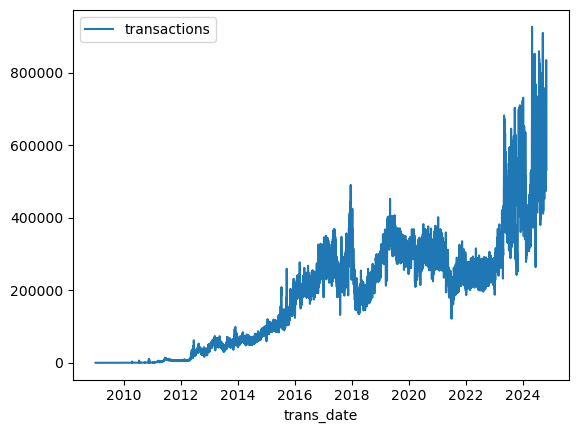

In [15]:
df_query.set_index('trans_date').plot()

As you can see, common table expressions (CTEs) let you shift a lot of your data cleaning into SQL. That's an especially good thing in the case of BigQuery, because it is vastly faster than doing the work in Pandas.



### Exercises
Fetch the `chicago_taxi_trips` dataset.

In [16]:
dataset_ref = client.dataset("chicago_taxi_trips", project="bigquery-public-data")

dataset = client.get_dataset(dataset_ref)

### 1) Find the data
Before you can access the data, you need to find the table name with the data.

In [18]:
tables = list(client.list_tables(dataset))

for table in tables:
    print (table.table_id)

taxi_trips


In [19]:
table_ref = dataset_ref.table("taxi_trips")

table = client.get_table(table_ref)

### 2) Peek at the data

Use the next code cell to peek at the top few rows of the data. Inspect the data and see if any issues with data quality are immediately obvious. 

In [20]:
client.list_rows(table, max_results=5).to_dataframe()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,5003bdd51918a9b5a52134096663b4d7e02395c5,2130bc5fd239a4e3b304662424fb4cc7db0ca7abf78cc5...,2013-02-25 14:15:00+00:00,2013-02-25 14:15:00+00:00,120,0.00,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,Cash,None,NaN,NaN,None,NaN,NaN,None
1,720534d264001b2644f682755b294067fdf1da21,4bb55b69e710d1792f5fd4888001f4ff0ce34040f976f8...,2013-06-02 08:15:00+00:00,2013-06-02 08:15:00+00:00,60,0.02,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,Cash,None,NaN,NaN,None,NaN,NaN,None
2,515b9a6d5234a4d1fb559dca27b3e1cc541a342d,4bb55b69e710d1792f5fd4888001f4ff0ce34040f976f8...,2013-06-24 06:15:00+00:00,2013-06-24 06:15:00+00:00,60,0.04,<NA>,<NA>,1,77,...,NaN,NaN,Cash,None,42.009623,-87.670167,POINT (-87.67016685690001 42.0096228806),41.986712,-87.663416,POINT (-87.6634164054 41.9867117999)
3,8afd48d966bf464e93127f43b72a8e405596a8eb,0150188f8c8e8973a198d4af0b427fca8ff48df2662d6b...,2013-02-01 07:00:00+00:00,2013-02-02 00:00:00+00:00,61560,0.00,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
4,fe73a44f01fdd2a3c740a01f53e97ec2ced93455,0150188f8c8e8973a198d4af0b427fca8ff48df2662d6b...,2013-02-01 07:00:00+00:00,2013-02-02 00:00:00+00:00,60900,0.00,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None


### 3) Determine when this data is from

If the data is sufficiently old, we might be careful before assuming the data is still relevant to traffic patterns today. Write a query that counts the number of trips in each year.  

Your results should have two columns:
- `year` - the year of the trips
- `num_trips` - the number of trips in that year

Hints:
- When using **GROUP BY** and **ORDER BY**, you should refer to the columns by the alias `year` that you set at the top of the **SELECT** query.
- The SQL code to **SELECT** the year from `trip_start_timestamp` is <code>SELECT EXTRACT(YEAR FROM trip_start_timestamp)</code>
- The **FROM** field can be a little tricky until you are used to it.  The format is:
    1. A backick (the symbol \`).
    2. The project name. In this case it is `bigquery-public-data`.
    3. A period.
    4. The dataset name. In this case, it is `chicago_taxi_trips`.
    5. A period.
    6. The table name. You used this as your answer in **1) Find the data**.
    7. A backtick (the symbol \`).

In [25]:
rides_per_year_query = """
        SELECT  EXTRACT(YEAR FROM trip_start_timestamp) as year,
                COUNT (1) as num_trips
        FROM    `bigquery-public-data.chicago_taxi_trips.taxi_trips`
        GROUP BY year
        ORDER BY num_trips DESC
"""

query_job = client.query(rides_per_year_query)

df_query = query_job.to_dataframe()

df_query.head()

,year,num_trips
0,2014,37395079
1,2015,32385527
2,2016,31756403
3,2013,27217300
4,2017,24979611


### 4) Dive slightly deeper

You'd like to take a closer look at rides from 2016.  Copy the query you used above in `rides_per_year_query` into the cell below for `rides_per_month_query`.  Then modify it in two ways:
1. Use a **WHERE** clause to limit the query to data from 2016.
2. Modify the query to extract the month rather than the year.

In [29]:
rides_per_month_query = """ 
        SELECT  EXTRACT(MONTH FROM trip_start_timestamp) as month,
                COUNT (1) as num_trips
        FROM    `bigquery-public-data.chicago_taxi_trips.taxi_trips`
        WHERE EXTRACT(YEAR FROM trip_start_timestamp) = 2016
        GROUP BY month
        ORDER BY num_trips DESC
"""

query_job = client.query(rides_per_month_query)

df_query = query_job.to_dataframe()

df_query.head()

,month,num_trips
0,5,2859147
1,4,2854290
2,3,2851106
3,6,2841872
4,10,2725340


### 5) Write the query

It's time to step up the sophistication of your queries.  Write a query that shows, for each hour of the day in the dataset, the corresponding number of trips and average speed.

Your results should have three columns:
- `hour_of_day` - sort by this column, which holds the result of extracting the hour from `trip_start_timestamp`.
- `num_trips` - the count of the total number of trips in each hour of the day (e.g. how many trips were started between 6AM and 7AM, independent of which day it occurred on).
- `avg_mph` - the average speed, measured in miles per hour, for trips that started in that hour of the day.  Average speed in miles per hour is calculated as `3600 * SUM(trip_miles) / SUM(trip_seconds)`. (The value 3600 is used to convert from seconds to hours.)

Restrict your query to data meeting the following criteria:
- a `trip_start_timestamp` > **2016-01-01** and < **2016-04-01**
- `trip_seconds` > 0 and `trip_miles` > 0

You will use a common table expression (CTE) to select just the relevant rides.  Because this dataset is very big, this CTE should select only the columns you'll need to create the final output (though you won't actually create those in the CTE -- instead you'll create those in the later **SELECT** statement below the CTE).

This is a much harder query than anything you've written so far.  Good luck!

In [40]:
speeds_query = """
               WITH RelevantRides AS
               (
                   SELECT EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day, 
                          trip_miles, 
                          trip_seconds
                   FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                   WHERE trip_start_timestamp > '2016-01-01' AND trip_start_timestamp < '2016-04-01' AND trip_seconds > 0 AND trip_miles > 0
               )
               SELECT   hour_of_day,
                        COUNT(1) as num_trips,
                        3600 * SUM(trip_miles)/SUM(trip_seconds) as avg_mph
               FROM RelevantRides
               GROUP BY hour_of_day
               ORDER BY hour_of_day
               """

query_job = client.query(speeds_query)

df_query = query_job.to_dataframe()

df_query.head()

,hour_of_day,num_trips,avg_mph
0,0,203092,20.191744
1,1,178046,18.628598
2,2,143447,18.444370
3,3,108899,19.273107
4,4,80067,27.599669
